# Training and Setup Toy Experiment
## Donkey Car Basic Convnet and/or some MNIST playarounds



In [0]:
pip install neptune-client #Install neptune client if not already installed


In [12]:
import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected



Project(charag/Littlefoot)

In [13]:
#Create and setup a neptune toy experiment: (Basic experiment - accuracy was manually logged at 93)

neptune.create_experiment(
    name='basic-colab-example',
    params={'learning_rate':0.1}
) #Create an experimint with a name and set default parameters

neptune.log_metric('accuracy', 0.93)  #Log a metric. This metric is manually logged at 93

neptune.append_tags(['basic', 'finished_successfully']) #Chart set for this experiment iteration is set  to be 'basic'

neptune.stop() #stop experiment

NVMLError: Driver Not Loaded - GPU usage metrics may not be reported.


https://ui.neptune.ai/charag/Littlefoot/e/LIT-4


## Neptune Classification Toy Example

In [0]:
pip install keras scikit-plot


In [0]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist #collect mnist dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data() #load mnist dataset into training and validation splits
x_train, x_test = x_train / 255.0, x_test / 255.0 #normalise training and validation images for pix values between 0 and 1

In [0]:
#create and compile a simple dense layer network
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [0]:
#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)

In [0]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [7]:

import neptune
neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to os environment variable
import neptune
EPOCH_NR = 6 #Select No of Epochs
BATCH_SIZE = 32 #Select batch size

neptune.create_experiment(name='keras-metrics',
                          params={'epoch_nr': EPOCH_NR,
                                  'batch_size': BATCH_SIZE},
                          tags=['keras_callback_logging'],
                          ) #Create a new neptune experiment named keras-metrics with the desired parameters set

https://ui.neptune.ai/charag/Littlefoot/e/LIT-7


Experiment(LIT-7)

In [8]:
#Train the model and call the neptune logger as the callback parameter

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=EPOCH_NR,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    callbacks=[NeptuneLogger()])

Epoch 1/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6414 - accuracy: 0.8331 - val_loss: 0.3453 - val_accuracy: 0.9064
Epoch 2/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3438 - accuracy: 0.9028 - val_loss: 0.2772 - val_accuracy: 0.9229
Epoch 3/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2891 - accuracy: 0.9175 - val_loss: 0.2459 - val_accuracy: 0.9302
Epoch 4/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2547 - accuracy: 0.9280 - val_loss: 0.2186 - val_accuracy: 0.9367
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2299 - accuracy: 0.9350 - val_loss: 0.1992 - val_accuracy: 0.9441
Epoch 6/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2095 - accuracy: 0.9420 - val_loss: 0.1829 - val_accuracy: 0.9469


In [0]:
#Get predictions and calculate an f1 score
import numpy as np

y_test_pred = np.asarray(model.predict(x_test))
y_test_pred_class = np.argmax(y_test_pred, axis=1)

from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_test_pred_class, average='micro')

neptune.log_metric('test_f1', f1)



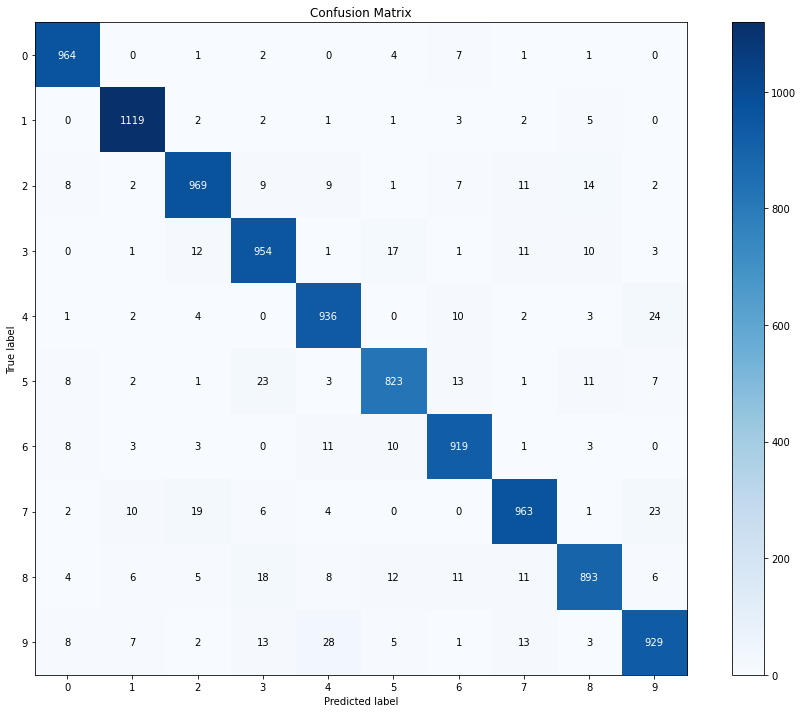

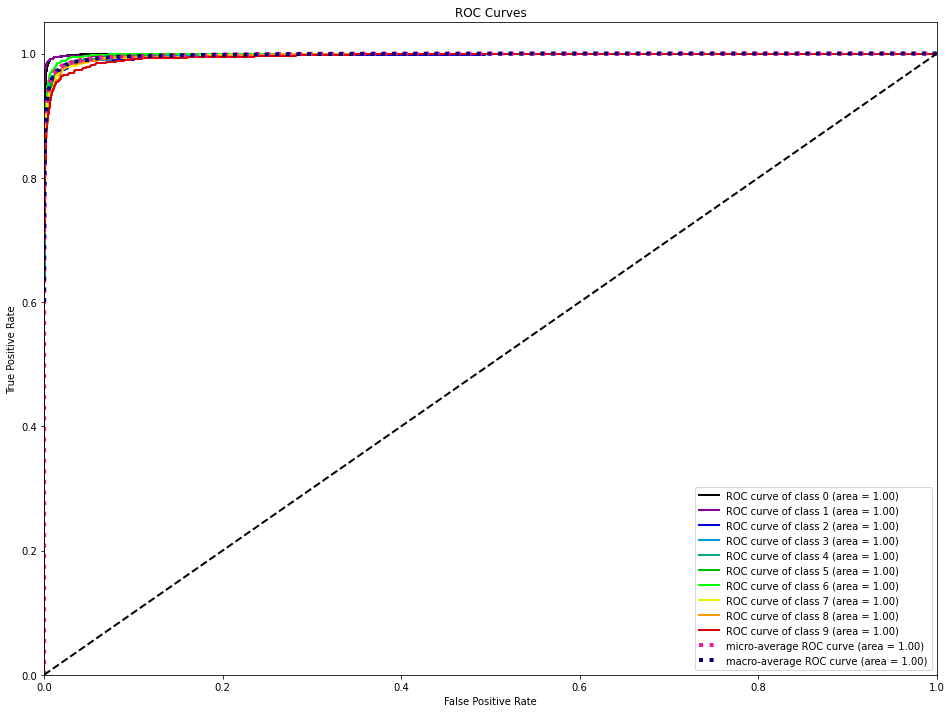

In [11]:
#Plot some other metrics (confusion matrix and AUC score)

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_test_pred_class, ax=ax)
neptune.log_image('diagnostic_charts', fig)

fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_test, y_test_pred, ax=ax)
neptune.log_image('diagnostic_charts', fig)

In [0]:
#log model weights to neptune as an artifact

model.save('my_model.h5')
neptune.log_artifact('my_model.h5')

In [0]:
neptune.stop() #stop experiments

### Access logged data and experiments programatically

In [14]:
from neptune import Session

session = Session.with_default_backend(api_token=None) #Use token in environment variable
my_project = session.get_project("charag/Littlefoot") #get littlefoot project

my_project.get_leaderboard(tag=['keras_callback_logging']).head() #get leaderboard of all experiments tagged with 'keras_callback_logging'


id           name  ... parameter_batch_size parameter_epoch_nr
0  LIT-7  keras-metrics  ...                 32.0                6.0

[1 rows x 18 columns]